# Setup 

## Imports

In [14]:
import pandas as pd
import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple
from joblib import Parallel, delayed


from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

## Configs e paths

In [19]:
FEATURE_DIR   = Path("../data/features/hmog_None")
RESULT_DIR    = Path("../data/results/svm")
RESULT_DIR.mkdir(parents=True, exist_ok=True)


SEED          = 42
SENSOR        = 'accelerometer' # or 'gyroscope' ou "acc-gyro"
MAX_SAMPLES   = 10000

feature_cols = { "accelerometer":
    [
        'acc_x_mean', 'acc_x_median', 'acc_x_std', 'acc_x_min', 'acc_x_max',
        'acc_y_mean', 'acc_y_median', 'acc_y_std', 'acc_y_min', 'acc_y_max',
        'acc_z_mean', 'acc_z_median', 'acc_z_std', 'acc_z_min', 'acc_z_max',
        'magnitude_mean', 'magnitude_std', 'magnitude_min', 'magnitude_max',
        'corr_xz', 'corr_yz'
    ],
    "gyroscope":
    [
        'gyro_x_mean', 'gyro_x_median', 'gyro_x_std', 'gyro_x_min', 'gyro_x_max',
        'gyro_y_mean', 'gyro_y_median', 'gyro_y_std', 'gyro_y_min', 'gyro_y_max',
        'gyro_z_mean', 'gyro_z_median', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max',
        'magnitude_mean', 'magnitude_std', 'magnitude_min', 'magnitude_max',
        'corr_xz', 'corr_yz'
    ],
    "multimodal":
    [
        'acc_x_mean', 'acc_x_median', 'acc_x_std', 'acc_x_min', 'acc_x_max',
        'acc_y_mean', 'acc_y_median', 'acc_y_std', 'acc_y_min', 'acc_y_max',
        'acc_z_mean', 'acc_z_median', 'acc_z_std', 'acc_z_min', 'acc_z_max',
        'acc_magnitude_mean', 'acc_magnitude_std', 'acc_magnitude_min', 'acc_magnitude_max',
        'acc_corr_xz', 'acc_corr_yz',
        'gyro_x_mean', 'gyro_x_median', 'gyro_x_std', 'gyro_x_min', 'gyro_x_max',
        'gyro_y_mean', 'gyro_y_median', 'gyro_y_std', 'gyro_y_min', 'gyro_y_max',
        'gyro_z_mean', 'gyro_z_median', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max',
        'gyro_magnitude_mean', 'gyro_magnitude_std', 'gyro_magnitude_min', 'gyro_magnitude_max',
        'gyro_corr_xz', 'gyro_corr_yz'
    ]
}
drop_cols = {"accelerometer": ['acc_x_skewness', 'acc_x_kurtosis','acc_y_skewness', 'acc_y_kurtosis',
                                'acc_z_skewness', 'acc_z_kurtosis','magnitude_skewness', 'magnitude_kurtosis'],
            "gyroscope": ['gyro_x_skewness', 'gyro_x_kurtosis','gyro_y_skewness', 'gyro_y_kurtosis',
                                'gyro_z_skewness', 'gyro_z_kurtosis','magnitude_skewness', 'magnitude_kurtosis']
        }


In [16]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", class_weight="balanced", probability=False, random_state=SEED)),
])

param_grid = {
    'svc__C': [0.1, 1, 10]
}

## Util functions

In [17]:
def _tar_at_far(fpr: np.ndarray, tpr: np.ndarray, target_far: float) -> float:
    if target_far <= fpr[0]:
        return tpr[0]

    if target_far >= fpr[-1]:
        return tpr[-1]
    idx = np.searchsorted(fpr, target_far) - 1

    fpr_low, fpr_high = fpr[idx], fpr[idx + 1]
    tpr_low, tpr_high = tpr[idx], tpr[idx + 1]
    alpha = (target_far - fpr_low) / (fpr_high - fpr_low + 1e-12)
    return tpr_low + alpha * (tpr_high - tpr_low)

def compute_metrics(y_true: np.ndarray, scores: np.ndarray) -> Dict[str, float]:
    fpr, tpr, _ = roc_curve(y_true, scores)
    fnr = 1 - tpr

    idx_eer = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[idx_eer] + fnr[idx_eer]) / 2

    metrics = {
        "EER": eer,
        "TAR_EER": tpr[idx_eer],
        "FAR_EER": fpr[idx_eer],
        "FRR_EER": fnr[idx_eer],
        "TAR_FAR_1pct": _tar_at_far(fpr, tpr, 0.01),
        "TAR_FAR_0.1pct": _tar_at_far(fpr, tpr, 0.001),
        "AUC": roc_auc_score(y_true, scores),
    }

    return metrics

In [11]:
def run_user(user_id: str, df: pd.DataFrame, modality: str, rng) -> pd.DataFrame:

    user_df = df.copy()
    user_df['label'] = (user_df['subject_id'] == user).astype(int)

    sessions = user_df.loc[user_df['label'] == 1, 'session_number'].unique()
    print(f"Total de sessões genuínas: {len(sessions)}")

    results = []
    for i, test_session in enumerate(sessions, start=1):
        ## SPLIT LOSO
        train_mask = user_df['session_number'] != test_session
        test_mask = user_df['session_number'] == test_session

        X_train_full = user_df.loc[train_mask, feature_cols.get(modality, [])]
        y_train_full = user_df.loc[train_mask, 'label']

        ## Cria subamostragem de impostores 
        pos_idx = y_train_full[y_train_full == 1].index
        neg_idx = y_train_full[y_train_full == 0].index
        
        n_pos = len(pos_idx)
        n_neg_sample = min(len(neg_idx), n_pos * 2) # 2x impostores
        neg_sample_idx = np.random.RandomState(SEED).choice(neg_idx, size=n_neg_sample, replace=False) 
        selected_idx = np.concatenate([pos_idx, neg_sample_idx])

        
        ## Limitar o número de amostras
        ## pegar leve com o pobi do notebook c:
        if len(selected_idx) > MAX_SAMPLES:
            selected_idx = rng.choice(selected_idx, size=MAX_SAMPLES, replace=False)
        
        X_train = X_train_full.loc[selected_idx]
        y_train = y_train_full.loc[selected_idx]

        X_test = user_df.loc[test_mask, feature_cols.get(modality)]
        y_test = user_df.loc[test_mask, 'label']

        # removendo linhas com NaN (algumas sessoes estavam me dando problemas)
        mask_test = X_test.notna().all(axis=1)
        X_test, y_test = X_test[mask_test], y_test[mask_test]

        print(f"Usuário {user_id} - Sessão {test_session} ({i}/{len(sessions)})")
        print(f" Treino original: {X_train_full.shape[0]} (pos={sum(y_train_full)}, neg={len(y_train_full)-sum(y_train_full)})")
        print(f" Treino subamostrado limitado a {MAX_SAMPLES} amostras: (pos={sum(y_train)}, neg={len(y_train)-sum(y_train)})")
        #print(f" Teste: {X_test.shape[0]} (pos={sum(y_test)}, neg={len(y_test)-sum(y_test)})")

        ## Treinamento    
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        grid = GridSearchCV(
            pipe,
            param_grid,
            cv=cv_inner,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        t0_train = time.perf_counter()
        grid.fit(X_train, y_train)
        t1_train = time.perf_counter()
        train_time_sec = t1_train - t0_train
        print(f" Treinamento concluído em {train_time_sec:.2f} segundos")

        ## Inferencia
        t0_infer = time.perf_counter()
        y_score_test = grid.decision_function(X_test)
        t1_infer = time.perf_counter()
        latency_ms = ((t1_infer - t0_infer) / len(y_test)) * 1000
        print(f" Inferência concluída em {latency_ms:.2f} ms por amostra")

        ## Metricas
        metrics_test = compute_metrics(y_test.values, y_score_test)
        
        ## Registrando resultados
        results.append({
            "user_id": user_id,
            "sensor": modality,
            "session": int(test_session),
            ## teste
            **{f"{k}_test": v for k, v in metrics_test.items()},
            "best_C": float(grid.best_params_["svc__C"]),
            "n_support_vec": int(grid.best_estimator_.named_steps["svc"].n_support_.sum()),
            "train_time_sec": train_time_sec,
            "latency_ms": latency_ms,
            "n_pos_train": int((y_train == 1).sum()),
            "n_neg_train": int((y_train == 0).sum()),
            "n_pos_test": int((y_test == 1).sum()),
            "n_neg_test": int((y_test == 0).sum()),
        })
    return pd.DataFrame(results)


## Main

In [20]:
MODALITIES = [
    ("accelerometer", FEATURE_DIR / "accelerometer_features.parquet"),
    ("gyroscope", FEATURE_DIR / "gyroscope_features.parquet"),
    ("multimodal", FEATURE_DIR / "multimodal_features.parquet"),
]
rng = np.random.default_rng(SEED)

NUM_USERS_EXPERIMENTO = 10
# Limitar o número de usuários para o experimento

for modality, path in MODALITIES:
    df = pd.read_parquet(path)
    all_users = df.subject_id.unique()
    users = rng.choice(all_users, size=NUM_USERS_EXPERIMENTO, replace=False)
    results = []
    for user in users:
        print(f"Processando usuário {user} para modalidade {modality}")
        result = run_user(user, df, modality, rng)
        results.append(result)
    results_df = pd.concat(results, ignore_index=True)
    out_file = f"data/results_{modality}.csv"
    results_df.to_csv(out_file, index=False)
    print(f"Resultados salvos em {out_file}")

Processando usuário 984799 para modalidade accelerometer
Total de sessões genuínas: 24
Usuário 984799 - Sessão 1 (1/24)
 Treino original: 2319392 (pos=18562, neg=2300830)
 Treino subamostrado limitado a 10000 amostras: (pos=3362, neg=6638)
 Treinamento concluído em 8.53 segundos
 Inferência concluída em 0.08 ms por amostra
Usuário 984799 - Sessão 2 (2/24)
 Treino original: 2318962 (pos=18837, neg=2300125)
 Treino subamostrado limitado a 10000 amostras: (pos=3364, neg=6636)
 Treinamento concluído em 8.25 segundos
 Inferência concluída em 0.08 ms por amostra
Usuário 984799 - Sessão 3 (3/24)
 Treino original: 2339723 (pos=18573, neg=2321150)
 Treino subamostrado limitado a 10000 amostras: (pos=3315, neg=6685)
 Treinamento concluído em 7.87 segundos
 Inferência concluída em 0.08 ms por amostra
Usuário 984799 - Sessão 4 (4/24)
 Treino original: 2326287 (pos=18452, neg=2307835)
 Treino subamostrado limitado a 10000 amostras: (pos=3369, neg=6631)
 Treinamento concluído em 7.30 segundos
 Infer

### Load dataframe

### Dataframe Info

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446046 entries, 0 to 2446045
Data columns (total 26 columns):
 #   Column          Dtype  
---  ------          -----  
 0   sensor          object 
 1   subject_id      object 
 2   session_number  int64  
 3   start_ms        int64  
 4   end_ms          int64  
 5   acc_x_mean      float64
 6   acc_x_median    float64
 7   acc_x_std       float64
 8   acc_x_min       float64
 9   acc_x_max       float64
 10  acc_y_mean      float64
 11  acc_y_median    float64
 12  acc_y_std       float64
 13  acc_y_min       float64
 14  acc_y_max       float64
 15  acc_z_mean      float64
 16  acc_z_median    float64
 17  acc_z_std       float64
 18  acc_z_min       float64
 19  acc_z_max       float64
 20  magnitude_mean  float64
 21  magnitude_std   float64
 22  magnitude_min   float64
 23  magnitude_max   float64
 24  corr_xz         float64
 25  corr_yz         float64
dtypes: float64(21), int64(3), object(2)
memory usage: 485.2+ MB


### User picking

In [99]:
users = df['subject_id'].unique()

rng = np.random.default_rng(SEED)
user = rng.choice(users)

print(f"Selected user: {user}")
results = {}

Selected user: 220962


### Train

In [100]:
results = {}

user_df = df.copy()
user_df['label'] = (user_df['subject_id'] == user).astype(int)

sessions = user_df.loc[user_df['label'] == 1, 'session_number'].unique()
print(f"Total de sessões genuínas: {len(sessions)}")

user_metrics = []

Total de sessões genuínas: 24


In [ ]:
for fold_id, test_session in enumerate(sessions, start=1):
    print(f"\n—— Fold {fold_id:02d} | Sessão {test_session} ——")

    ## SPLIT LOSO
    train_mask = user_df['session_number'] != test_session
    test_mask = user_df['session_number'] == test_session

    X_train_full = user_df.loc[train_mask, feature_cols.get(SENSOR, [])]
    y_train_full = user_df.loc[train_mask, 'label']

    ## Cria subamostragem de impostores 
    pos_idx = y_train_full[y_train_full == 1].index
    neg_idx = y_train_full[y_train_full == 0].index
    
    n_pos = len(pos_idx)
    n_neg_sample = min(len(neg_idx), n_pos * 2) # 2x impostores
    neg_sample_idx = np.random.RandomState(SEED).choice(neg_idx, size=n_neg_sample, replace=False) 
    selected_idx = np.concatenate([pos_idx, neg_sample_idx])

    ## Limitar o número de amostras
    ## pegar leve com o pobi do notebook c:
    if len(selected_idx) > MAX_SAMPLES:
        selected_idx = rng.choice(selected_idx, size=MAX_SAMPLES, replace=False)
    
    X_train = X_train_full.loc[selected_idx]
    y_train = y_train_full.loc[selected_idx]

    X_test = user_df.loc[test_mask, feature_cols.get(SENSOR)]
    y_test = user_df.loc[test_mask, 'label']

    # removendo linhas com NaN (algumas sessoes estavam me dando problemas)
    mask_test = X_test.notna().all(axis=1)
    X_test, y_test = X_test[mask_test], y_test[mask_test]


    print(f" Treino original: {X_train_full.shape[0]} (pos={sum(y_train_full)}, neg={len(y_train_full)-sum(y_train_full)})")
    print(f" Treino subamostrado limitado a {MAX_SAMPLES} amostras: (pos={sum(y_train)}, neg={len(y_train)-sum(y_train)})")
    #print(f" Teste: {X_test.shape[0]} (pos={sum(y_test)}, neg={len(y_test)-sum(y_test)})")

    ## Treinamento    
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=cv_inner,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    t0_train = time.perf_counter()
    grid.fit(X_train, y_train)
    t1_train = time.perf_counter()
    train_time_sec = t1_train - t0_train
    print(f" Treinamento concluído em {train_time_sec:.2f} segundos")

    ## Inferencia
    t0_infer = time.perf_counter()
    y_score_test = grid.decision_function(X_test)
    t1_infer = time.perf_counter()
    latency_ms = ((t1_infer - t0_infer) / len(y_test)) * 1000
    print(f" Inferência concluída em {latency_ms:.2f} ms por amostra")

    ## Metricas
    metrics_test = compute_metrics(y_test.values, y_score_test)
    
    ## Registrando resultados
    fold_results = {
        "sensor": SENSOR,
        "session": int(test_session),
        ## teste
        **{f"{k}_test": v for k, v in metrics_test.items()},
        "best_C": float(grid.best_params_["svc__C"]),
        "n_support_vec": int(grid.best_estimator_.named_steps["svc"].n_support_.sum()),
        "train_time_sec": train_time_sec,
        "latency_ms": latency_ms,
        "n_pos_train": int((y_train == 1).sum()),
        "n_neg_train": int((y_train == 0).sum()),
        "n_pos_test": int((y_test == 1).sum()),
        "n_neg_test": int((y_test == 0).sum()),
    }
    user_metrics.append(fold_results)


—— Fold 01 | Sessão 1 ——
 Treino original: 2319392 (pos=22697, neg=2296695)
 Treino subamostrado limitado a 13000 amostras: (pos=4360, neg=8640)
 Treinamento concluído em 20.94 segundos
 Inferência concluída em 0.06 ms por amostra

—— Fold 02 | Sessão 2 ——
 Treino original: 2318962 (pos=22859, neg=2296103)
 Treino subamostrado limitado a 13000 amostras: (pos=4361, neg=8639)
 Treinamento concluído em 19.44 segundos
 Inferência concluída em 0.06 ms por amostra

—— Fold 03 | Sessão 3 ——
 Treino original: 2339723 (pos=23329, neg=2316394)
 Treino subamostrado limitado a 13000 amostras: (pos=4329, neg=8671)
 Treinamento concluído em 19.11 segundos
 Inferência concluída em 0.06 ms por amostra

—— Fold 04 | Sessão 4 ——
 Treino original: 2326287 (pos=23216, neg=2303071)
 Treino subamostrado limitado a 13000 amostras: (pos=4353, neg=8647)
 Treinamento concluído em 19.80 segundos


KeyboardInterrupt: 

### Results

In [ ]:
results[user] = pd.DataFrame(user_metrics)
filepath = RESULT_DIR / f"{SENSOR}"
if not filepath.exists():
    filepath.mkdir(parents=True)

In [ ]:
filename = filepath / f"{user}_results.parquet"

results[user].to_parquet(filename, index=False)

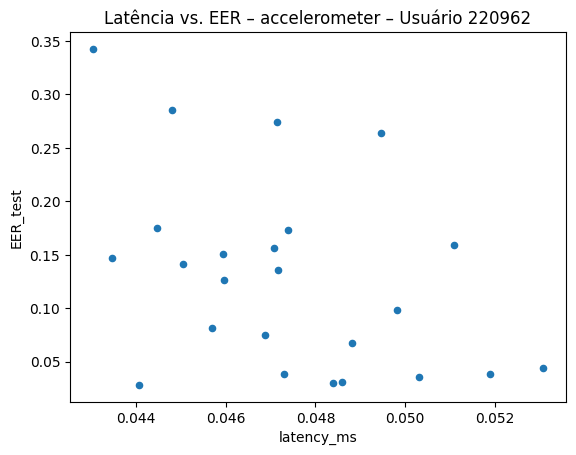

In [ ]:
try:
    import matplotlib.pyplot as plt

    results[user].plot(
        kind="scatter",
        x="latency_ms",
        y="EER_test",
        title=f"Latência vs. EER – {SENSOR} – Usuário {user}",
    )
    plt.show()
except Exception as e:
    print(f"[WARN] Não foi possível exibir scatter: {e}")